Chapter 2 - Gaussian Bayesian Networks - structural learning from data

The crop data <br>
G = genetic potential <br>
E = environmental potential <br>
V = vegatative mass <br>
N = number of seeds (@ flowering time) <br>
W = average weight (later in plants life) <br>
C = crop <br>

$G\sim N(50, 10^2)$ <br>
$E \sim N(50, 10^2)$ <br>
$V \mid G = g,E=e \sim N(-10.35 + 0.5g+0.70e, 5^2)$ <br>
$N \mid V = v \sim N(45 + 0.1v, 9.95^2)$<br>
$W \mid V = v \sim N(15 + 0.7v, 7.14^2)$<br>
$C \mid N = n, W = w \sim N(0.3n + 0.7w, 6.25^2)$<br>

In [ ]:
install.packages(
  "bnlearn",
  repos = "https://cloud.r-project.org",   # CRAN mirror
  dependencies = TRUE                      # pulls in igraph, gRain, etc.
)
library(bnlearn)

In [22]:
install.packages(
  "rbmn",
  repos = "https://cloud.r-project.org",   # CRAN mirror
  dependencies = TRUE                      # pulls in igraph, gRain, etc.
)
library(rbmn)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [51]:
install.packages(
  "corpcor",
  repos = "https://cloud.r-project.org",   # CRAN mirror
  dependencies = TRUE                      # pulls in igraph, gRain, etc.
)
library(corpcor)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [52]:
# From Lab 7 -- the paramaterization
# Specify the BN (from formula --> graph)
dag.bnlearn <- model2network("[G][E][V|G:E][N|V][W|V][C|N:W]")

# Specify the distributions
disE <- list(coef = c("(Intercept)" = 50), sd = 10)
disG <- list(coef = c("(Intercept)" = 50), sd = 10)
disV <- list(coef = c("(Intercept)" = -10.35, E = .70, G = 0.5), sd = 5)
disN <- list(coef = c("(Intercept)" = 45, V = .1), sd = 9.95)
disW <- list(coef = c("(Intercept)" = 15, V = 0.7), sd = 7.14)
disC <- list(coef = c("(Intercept)" = 0, N = 0.3, W = 0.7), sd = 6.25)

# put them together for bn parameterization
dis.list <- list(E = disE, G = disG, V = disV, N = disN, W = disW, C = disC)

gbn.bnlearn <- custom.fit(dag.bnlearn, dist = dis.list)

In [53]:
# From Lab 8
# convert my bn object over to rbmn (by the book)

#class(gbn.bnlearn)
gbn.rbmn <- bnfit2nbn(gbn.bnlearn)
gema.rbmn <- nbn2gema(gbn.rbmn)
mn.rbmn <- gema2mn(gema.rbmn)

set.seed(123)
cropdata0 <- rbn(gbn.bnlearn, n = 10) # very small sample size
cropdata1 <- rbn(gbn.bnlearn, n = 500) # moderate size
cropdata2 <- rbn(gbn.bnlearn, n = 5000) # larger (but not large)

## Correlation and Partial Correlation

In [54]:
cormat <- cor(cropdata1[ , c("C", "W", "N")]) # get the correlation matrix
cormat

,C,W,N
C,1.0000000,0.67601400,0.38112023
W,0.6760140,1.00000000,0.04594724
N,0.3811202,0.04594724,1.00000000


In [57]:
?cor2pcor

In [56]:
invcor <- cor2pcor(cormat) # cor2pcor computes pairwise partial correlation from correlation/covariance matrix
dimnames(invcor) <- dimnames(cormat)
invcor

,C,W,N
C,1.0000000,0.7130131,0.4755526
W,0.7130131,1.0000000,-0.3107353
N,0.4755526,-0.3107353,1.0000000


## Correlation Tests

In [59]:
# single conditional independence test
#?ci.test
ci.test("C", "W", "N", test = "cor", data = cropdata1) # yes, dependence as we reject null hypothesis | test for partial correlation b/w C & W given N


	Pearson's Correlation

data:  C ~ W | N
cor = 0.71301, df = 497, p-value < 2.2e-16
alternative hypothesis: true value is not equal to 0


In [60]:
# now let's work on the entire dataset:
# simultaneous testing between all pairs of variables
stru1 <- iamb(cropdata1, test = "cor")
stru1


  Bayesian network learned via Constraint-based methods

  model:
   [E][G][N][V|E:G][W|V][C|N:W] 
  nodes:                                 6 
  arcs:                                  5 
    undirected arcs:                     0 
    directed arcs:                       5 
  average markov blanket size:           2.33 
  average neighbourhood size:            1.67 
  average branching factor:              0.83 

  learning algorithm:                    IAMB 
  conditional independence test:         Pearson's Correlation 
  alpha threshold:                       0.05 
  tests used in the learning procedure:  155 


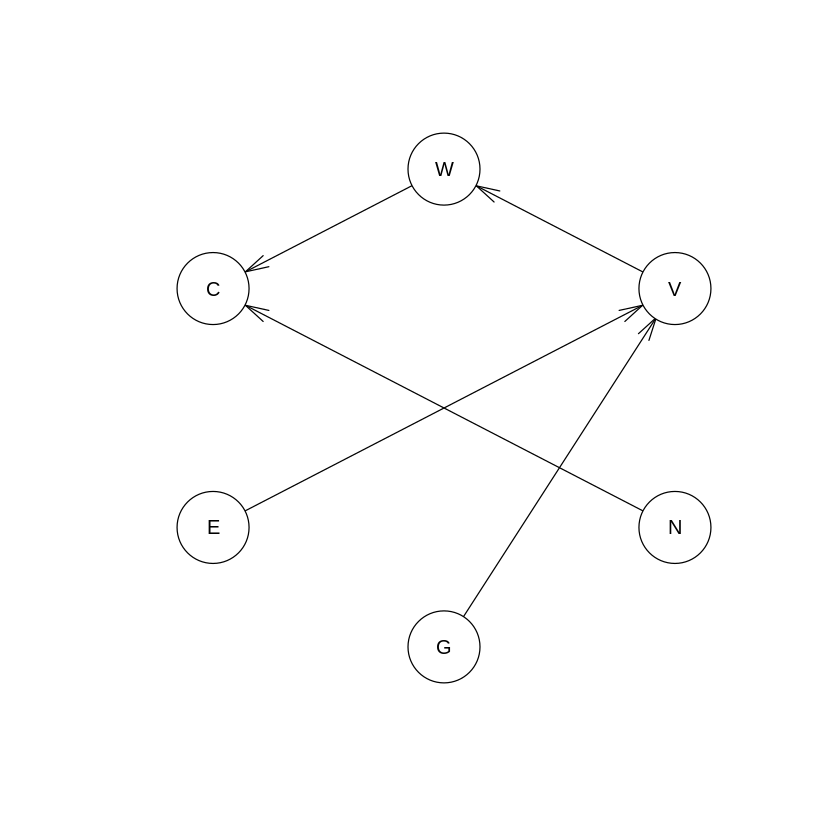

In [61]:
plot(stru1) # this is the network that is inferred from the structure based on conditional independence tests

In [62]:
# If i were to use cropdata0 the structure would be a lot different because the evidence is going to be much weaker especially id we are talking about hypothesis testing

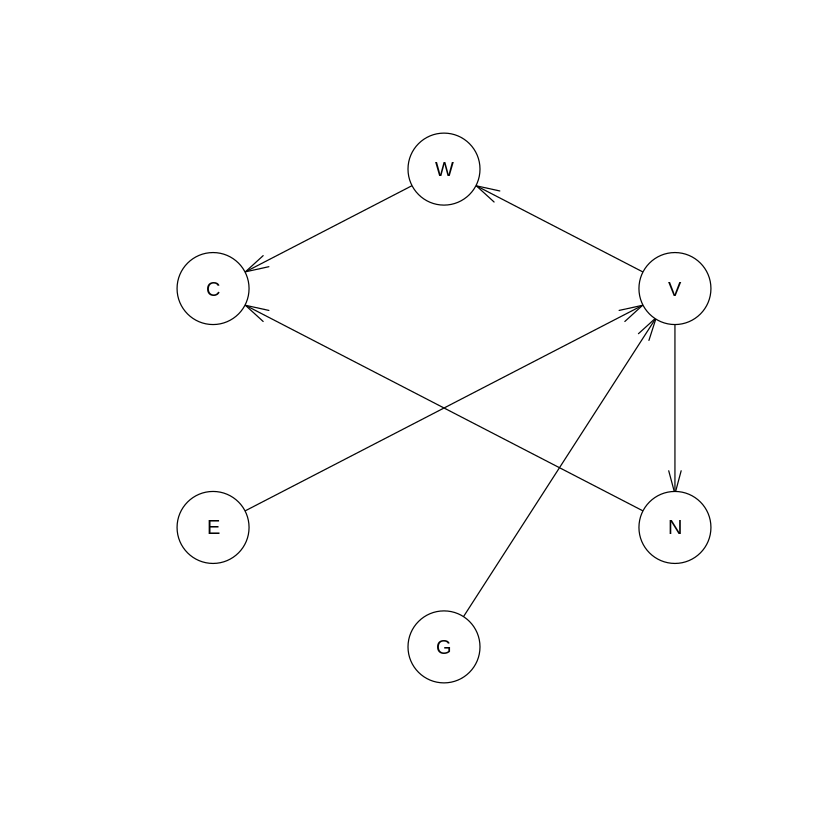

In [63]:
# Let's look at the structure when a larger sample size is used
stru2 <- iamb(cropdata2, test = "cor")

plot(stru2)

In [64]:
all.equal(stru1, stru2) # these are different

[1] "Different number of directed/undirected arcs"

In [65]:
# Question which one is closer to the "true" (true is dag that we made out of expert knowledge)
all.equal(stru2, dag.bnlearn) # Answer: larger sample size is better!

[1] TRUE

In [ ]:
# But, what if we know that there is an edge going from V to N, we can enforce this using a whitelist

V,N


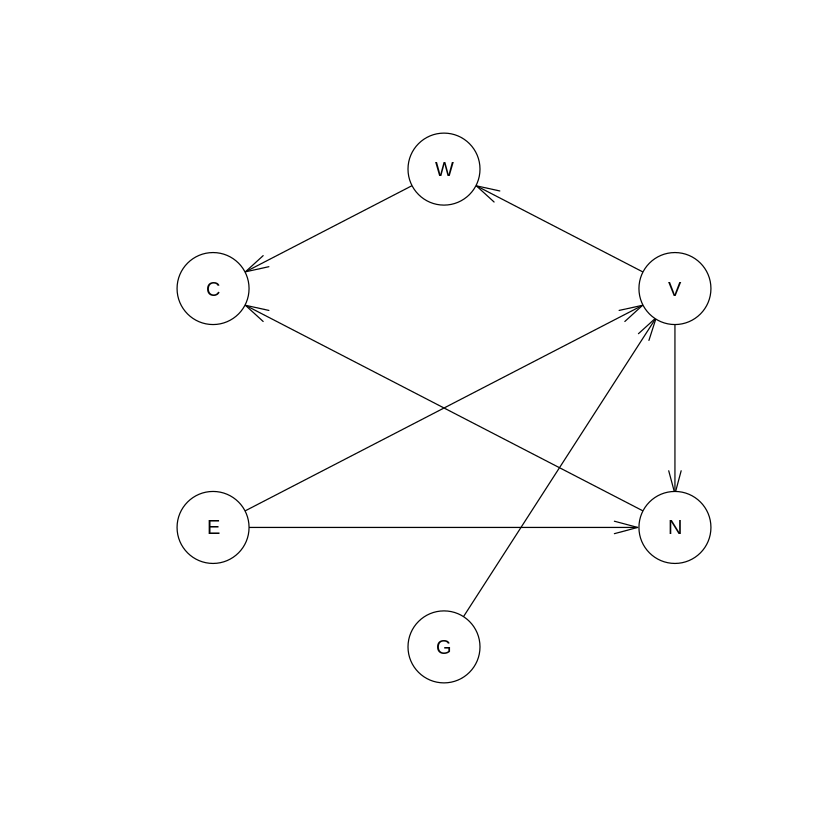

In [67]:
# White list - force edges -- it also can create a hierarchy
w1 <- matrix(c("V", "N"), ncol = 2)
w1

stru3 <- iamb(cropdata1, test = "cor", whitelist = w1)
plot(stru3) # we did enforce V->N but now we have an extra E->N

In [68]:
# Compute 'scores' for Gaussian BNs
score(dag.bnlearn, data = cropdata2, type = "bic-g")
score(dag.bnlearn, data = cropdata2, type = "bge")

[1] -104171.9

[1] -104245.2